In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import sys
from datetime import datetime

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import sys
from datetime import datetime
# DOESN'T WORK WITH GEOPOTENTIAL, too large
# Define a function to open datasets and concatenate them
def open_and_concatenate(year, variable, months, way, level=0):
    datasets = []
    for month in months:
        dataset = xr.open_dataset(f'{way}{variable}/ERA5_{year}-{month}_{variable}.nc')
        if variable == 'geopotential' and level != 0:
            dataset = dataset.sel(level=level)
        
        # Create a date range with 3-hour intervals starting from midnight
        start = pd.Timestamp(f"{year}-{month}-01 00:00:00")
        if month == 12:
            end = pd.date_range(start=f"{year}-{month}-01", end=f"{str(int(year)+1)}-01-01", freq='M')[0] + pd.Timedelta(hours=21)
        else:
            end = pd.date_range(start=f"{year}-{month}-01", end=f"{year}-{month+1}-01", freq='M')[0] + pd.Timedelta(hours=21)
        date_range = pd.date_range(start, end, freq='3H')

        # Select the data at the specific timesteps
        dataset = dataset.sel(time=date_range)
        
        datasets.append(dataset)
        dataset.close()

    return xr.concat(datasets, dim='time')

'''# Define a function to calculate statistics
def calculate_statistics(data_array):
    return {
        'mean': np.mean(data_array),
        'min': np.min(data_array),
        'max': np.max(data_array),
        'std': np.std(data_array),
    }'''

# Function to log processing details
def log_processing(variable, year, level, storm_number):
    timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    log_message = f'Processed variable: {variable}, Year: {year}, Level: {level}, Timestamp: {timestamp}, Storm number:{storm_number}'
    with open(f'/work/FAC/FGSE/IDYST/tbeucler/default/fabien/repos/curnagl/climatology/logs/processing_log_3h.txt', 'a') as log_file:
        log_file.write(log_message + '\n')

# Main function to process data
def process_data(variable, year, level=0):
    year = int(year)
    year_next = year + 1
    month_act = [10, 11, 12]
    month_next = [1, 2, 3]
    if variable == 'geopotential':
        way = '/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF/ERA5_hourly_PL/'
    else:
        way = '/work/FAC/FGSE/IDYST/tbeucler/default/raw_data/ECMWF/ERA5/SL/'

    # Open and concatenate datasets
    if year == 1990:
        dataset_act = open_and_concatenate(str(year), variable, month_next, way, level)
        dataset_next = open_and_concatenate(str(year_next), variable, month_next, way, level)
        dataset = xr.concat([dataset_act, dataset_next], dim='time')
        dataset = dataset.chunk({'time': 10})
    elif year == 2021:
        dataset = open_and_concatenate(str(year), variable, month_next, way, level)
    else:
        dataset_act = open_and_concatenate(str(year), variable, month_act, way, level)
        dataset_next = open_and_concatenate(str(year_next), variable, month_next, way, level)
        dataset = xr.concat([dataset_act, dataset_next], dim='time')
        dataset = dataset.chunk({'time': 10})

    # Determine the specific variable to extract
    specific_var = next(var for var in dataset.variables if var not in ['longitude', 'latitude', 'time', 'level'])

    # Import all tracks and convert dates
    dates = pd.read_csv(f'/work/FAC/FGSE/IDYST/tbeucler/default/fabien/repos/curnagl/storms_start_end.csv', parse_dates=['start_date', 'end_date'])
    dates['year'] = dates['start_date'].dt.year

    # Find the indices for storms within the specified timeframe
    if year == 1990:
        index_start_october = dates[(dates['start_date'].dt.month <= 3) & (dates['start_date'].dt.year == year)].index[0]
        index_end_march = dates[(dates['end_date'].dt.month <= 3) & (dates['end_date'].dt.year == year_next)].index[0]
    elif year == 2021:
        index_start_october = dates[(dates['start_date'].dt.month <= 3) & (dates['start_date'].dt.year == year)].index[0]
        index_end_march = dates[(dates['end_date'].dt.year == 2021)].index[0]
    else:
    # Chercher start_october dans year, sinon chercher dès janvier de year_next
        index_start_october = dates[((dates['start_date'].dt.month >= 10) & (dates['start_date'].dt.year == year)) | ((dates['start_date'].dt.year == year_next) & (dates['start_date'].dt.month >= 1))].index[0]
        index_end_march_first = dates[((dates['end_date'].dt.month <= 3) & (dates['end_date'].dt.year == year_next))].index
        #print(index_start_october, index_end_march_first, '3rd condition start_october + index_end_march_first')
        if len(index_end_march_first) > 0:
            index_end_march = index_end_march_first[-1]
            #print(index_end_march, 'index_end_march 1st condition of 2nd condition')
        else:
            # Si year_next ne renvoie rien, chercher la dernière instance de tempête dans year
            index_end_march = dates[((dates['end_date'].dt.year == year) & (dates['end_date'].dt.month <= 12))].index[-1]
            #print(index_end_march, 'index_end_march 2nd condition of 2nd condition')
    # Process each storm
    for i in range(index_start_october, index_end_march + 1):
        track = pd.read_csv(f'/work/FAC/FGSE/IDYST/tbeucler/default/fabien/repos/curnagl/tc_irad_tracks/tc_3_hours/tc_irad_{i+1}.txt')
        start_date = dates.at[i, 'start_date']
        end_date = dates.at[i, 'end_date']
        storm_data = dataset[specific_var].sel(time=slice(start_date, end_date))
        # Save the storm data to a NetCDF file
        storm_data.to_netcdf(f'/work/FAC/FGSE/IDYST/tbeucler/default/fabien/repos/curnagl/climatology/datasets_3h/{variable}/{variable}_{i+1}_{level}.nc')

        '''# Initialize lists to store statistics
        stats = {'mean': [], 'min': [], 'max': [], 'std': []}
        #, 'skewness': [], 'kurtosis': []

        # Calculate statistics for each time step
        for time_step in storm_data.time:
            data_slice = storm_data.sel(time=time_step).values
            step_stats = calculate_statistics(data_slice)
            for key in stats:
                stats[key].append(step_stats[key])

        # Save statistics to CSV files
        for key in stats:
            pd.DataFrame(stats[key]).to_csv(f'/work/FAC/FGSE/IDYST/tbeucler/default/fabien/repos/curnagl/datasets_3h/{variable}/storm_{i+1}/{key}_{i+1}_{level}.csv')
'''
    # Log the processing details
    log_processing(variable, year, level, i+1)

if __name__ == '__main__':
    variable = '2m_temperature' #sys.argv[1]
    year = 1990 #sys.argv[2]
    level = 0 #int(sys.argv[3])
    process_data(variable, year, level)

In [2]:
ds = xr.open_dataset('/work/FAC/FGSE/IDYST/tbeucler/default/fabien/repos/curnagl/climatology/datasets_3h/2m_temperature/2m_temperature_1_0.nc')
ds

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 62)
Coordinates:
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * time       (time) datetime64[ns] 1990-01-21T03:00:00 ... 1990-01-28T18:00:00
Data variables:
    2t         (time, latitude, longitude) float32 ...

216.49162 319.91754


/tmp/44419374/ipykernel_1079799/3721268060.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()
/tmp/44419374/ipykernel_1079799/3721268060.py:19: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  gifs = [imageio.imread(image) for image in images]


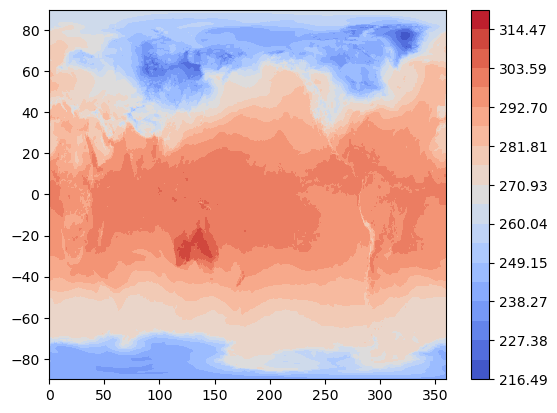

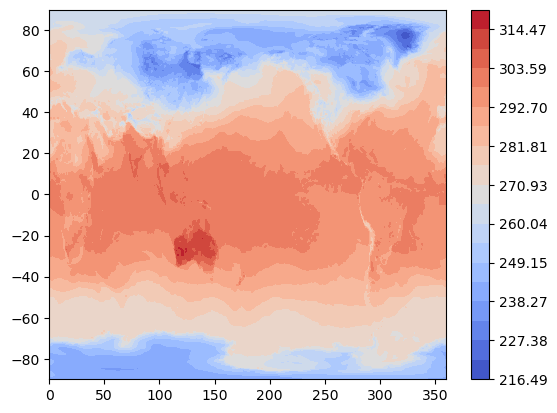

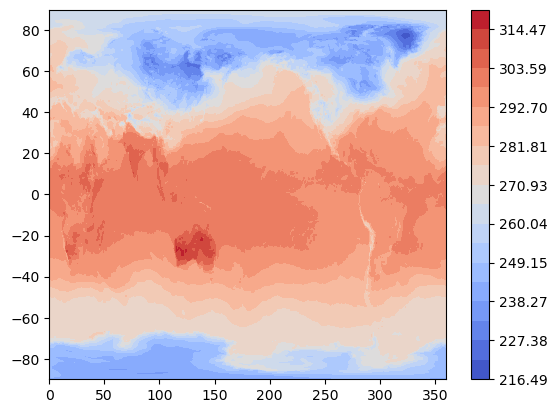

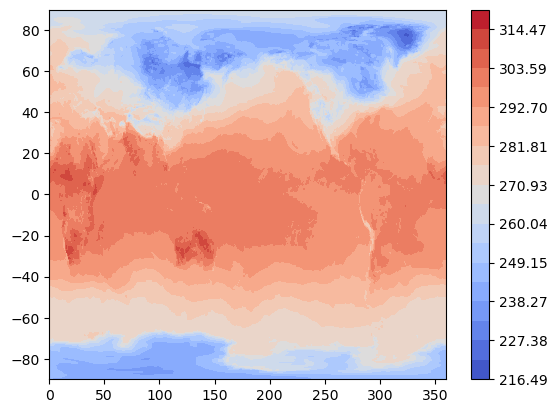

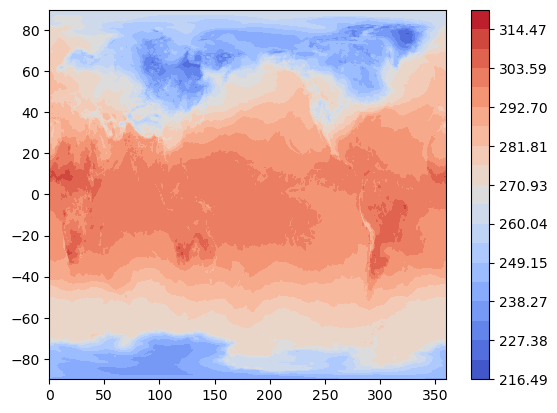

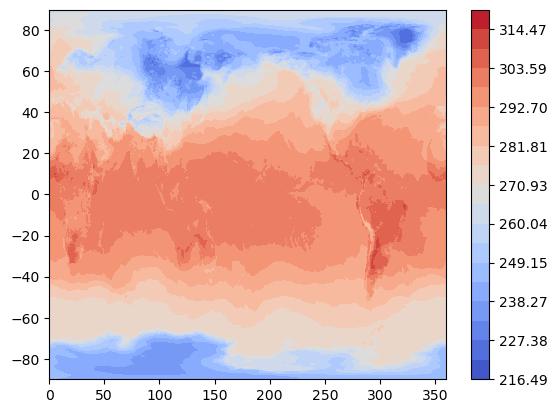

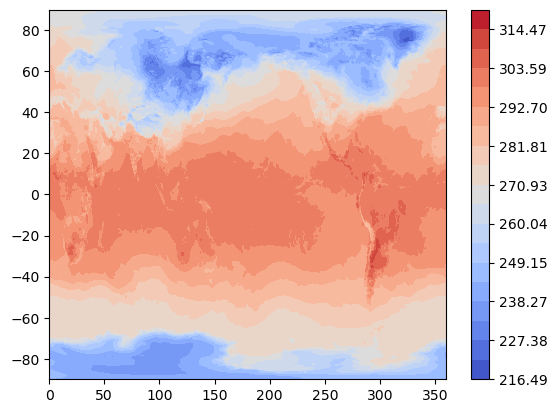

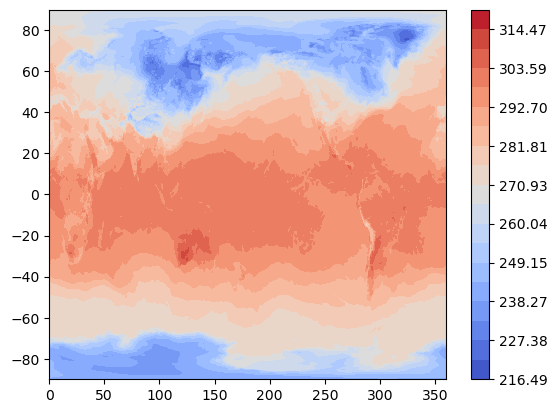

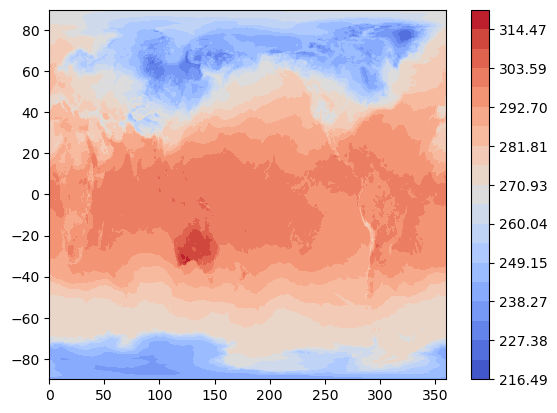

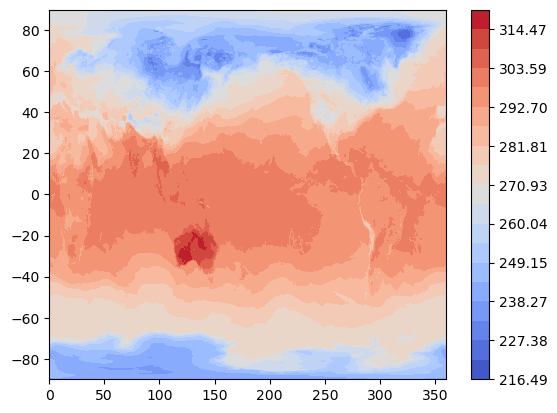

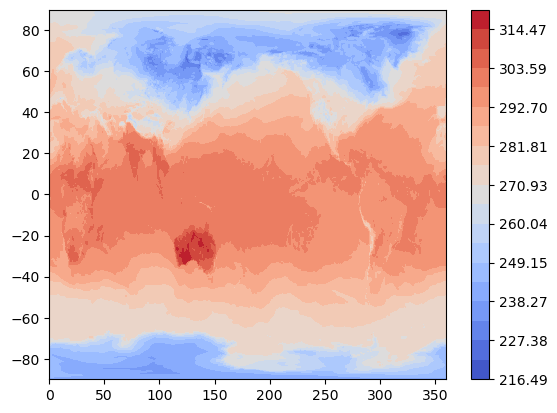

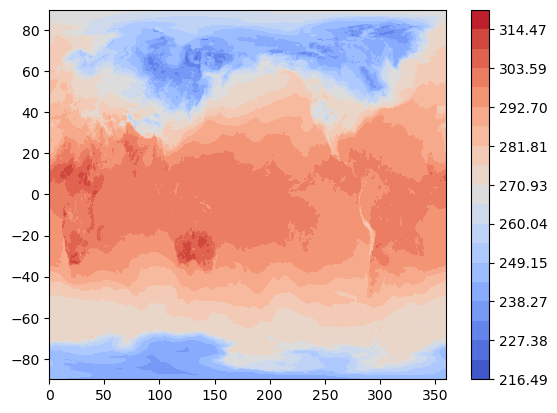

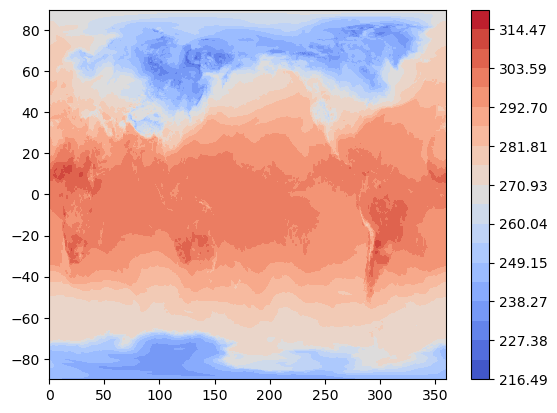

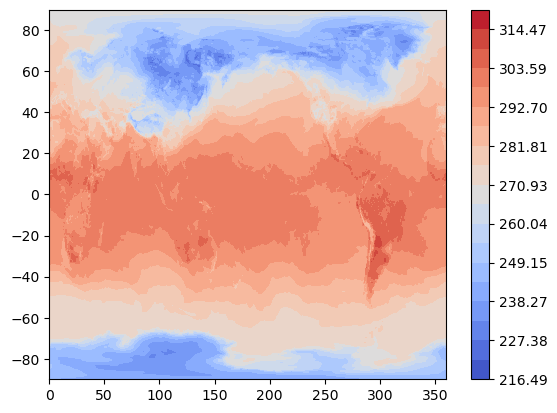

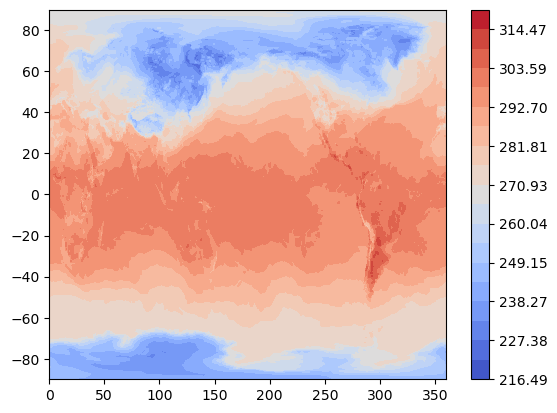

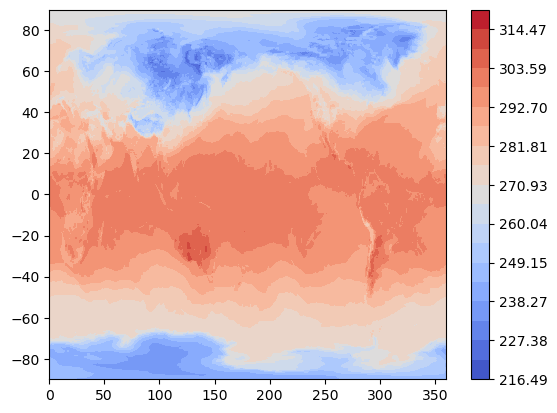

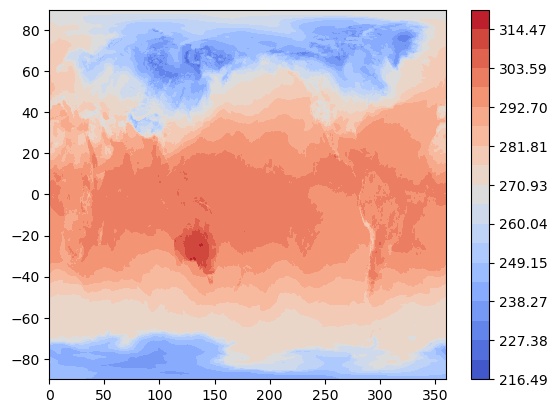

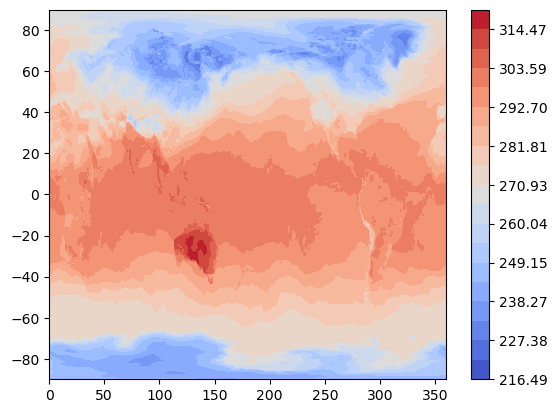

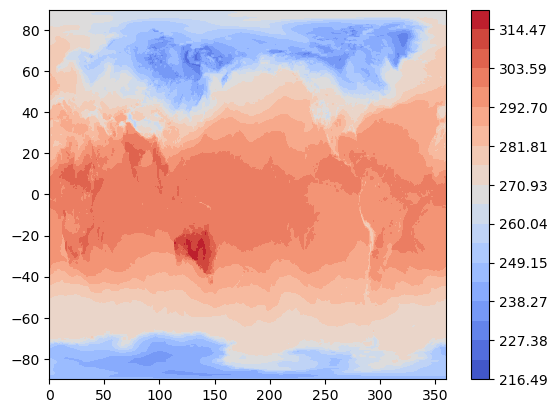

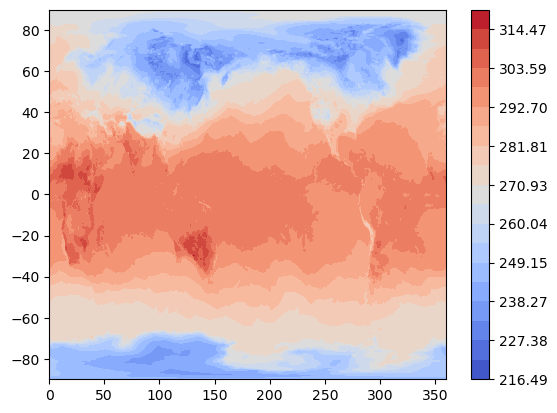

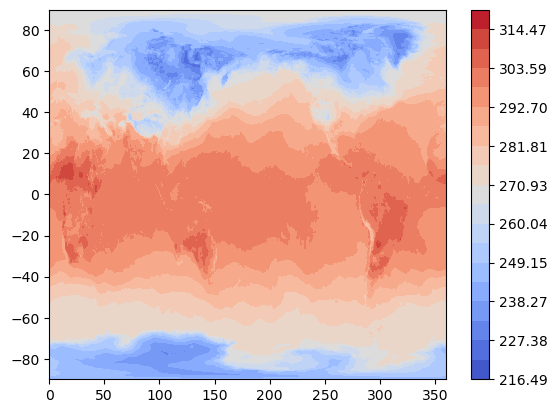

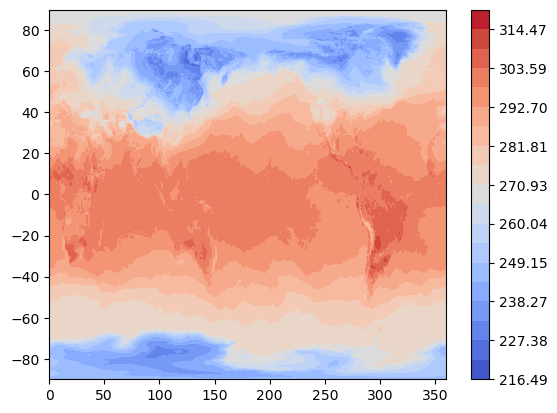

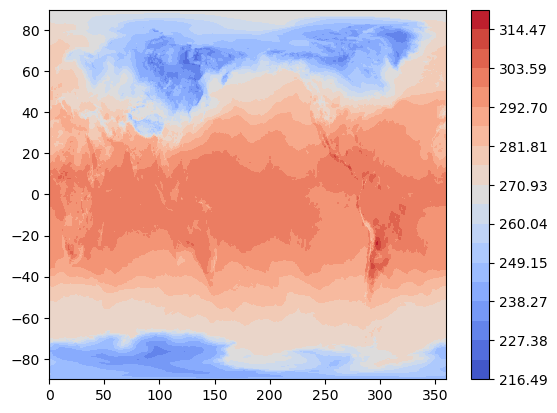

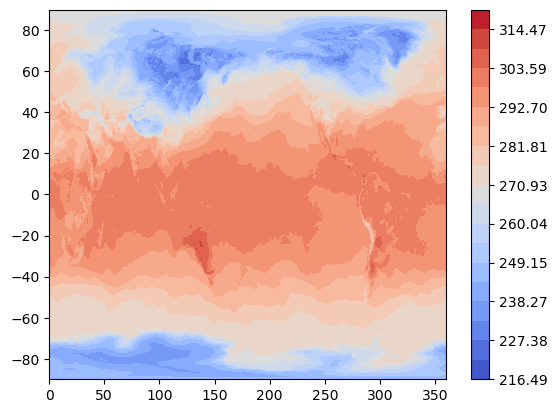

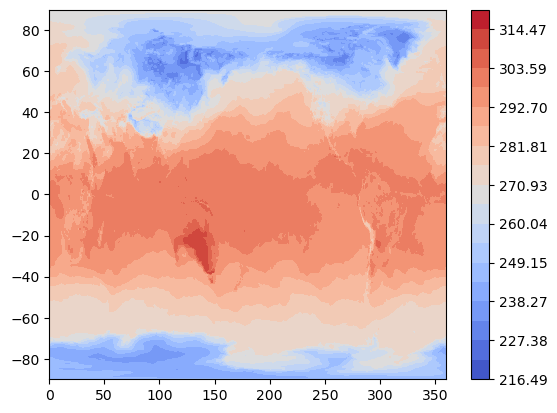

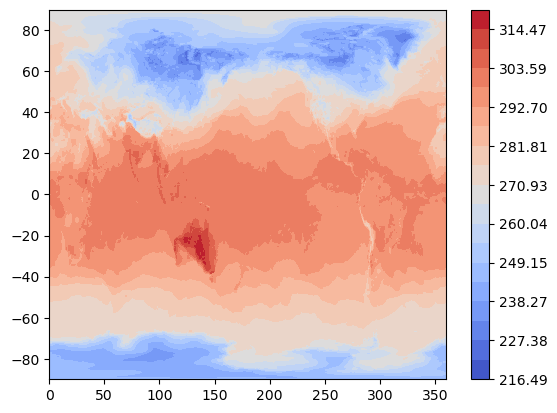

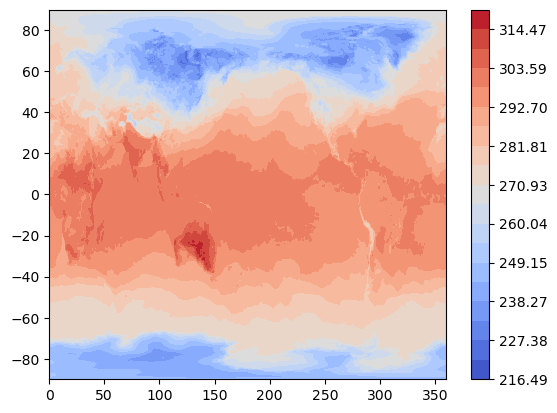

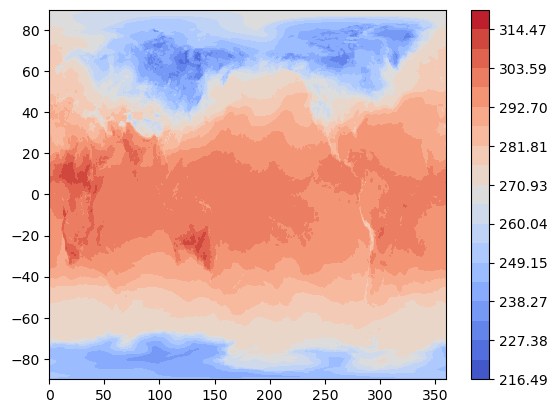

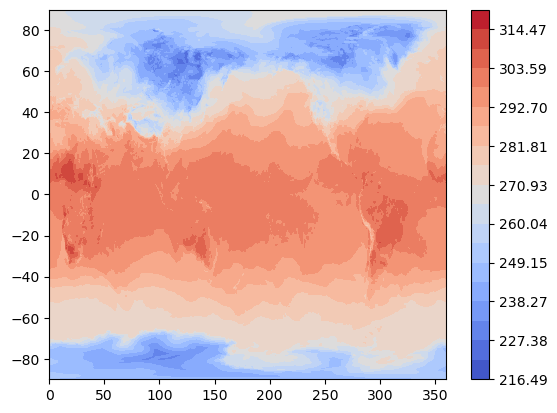

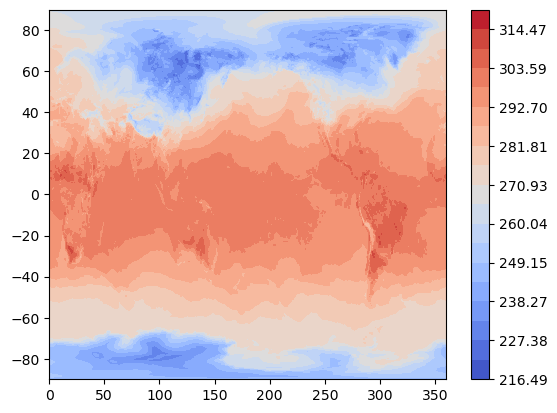

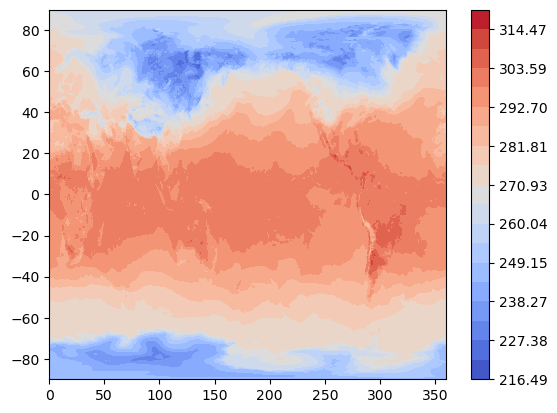

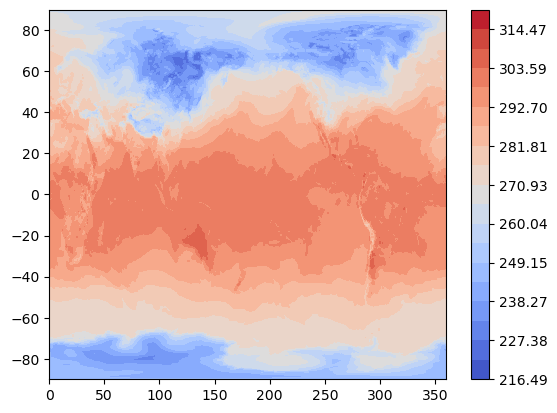

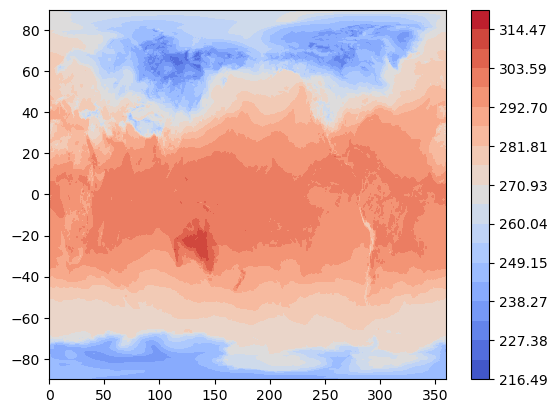

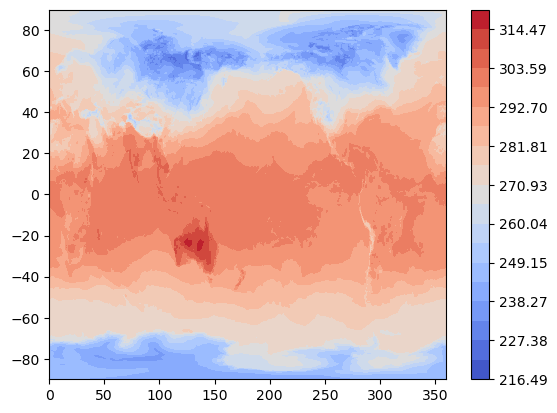

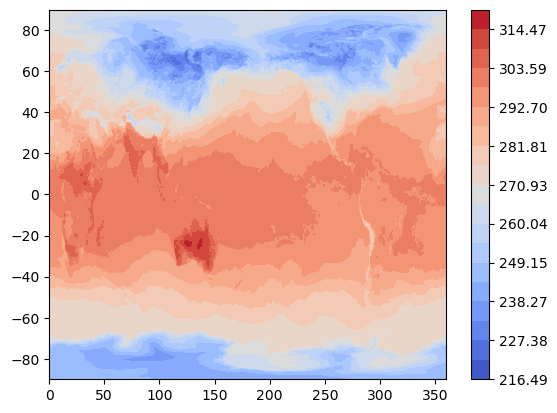

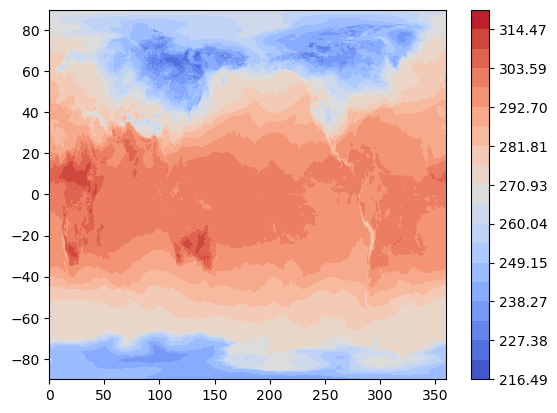

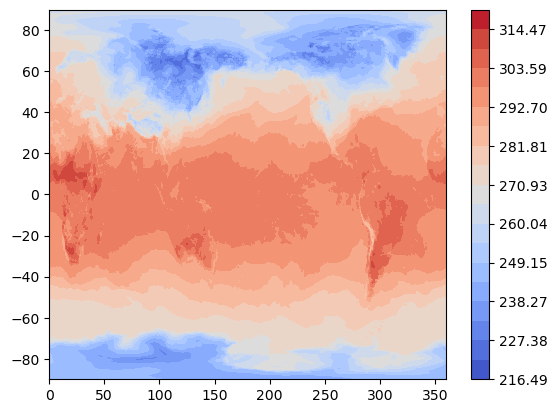

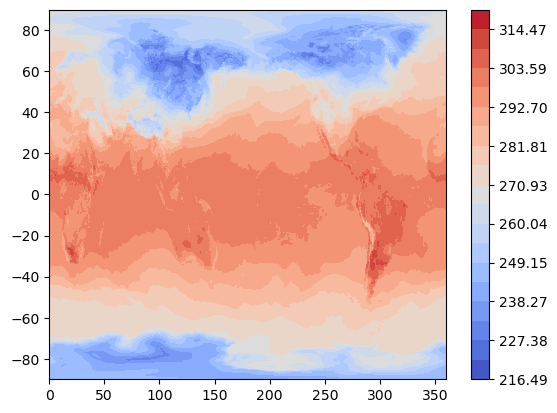

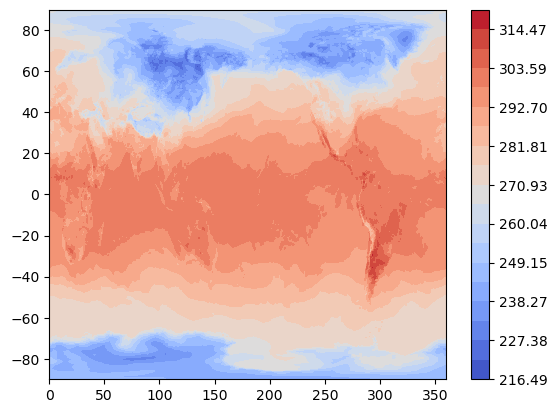

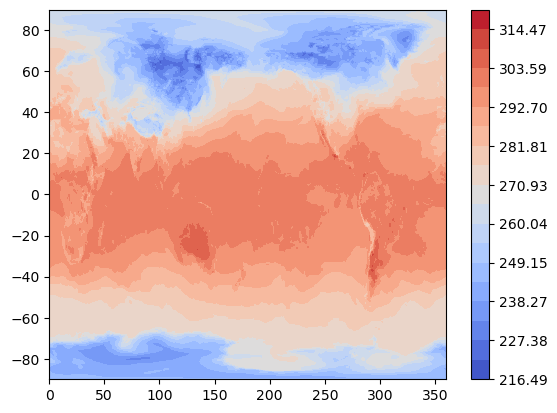

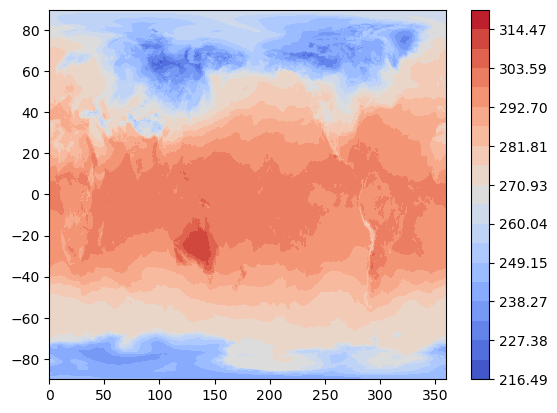

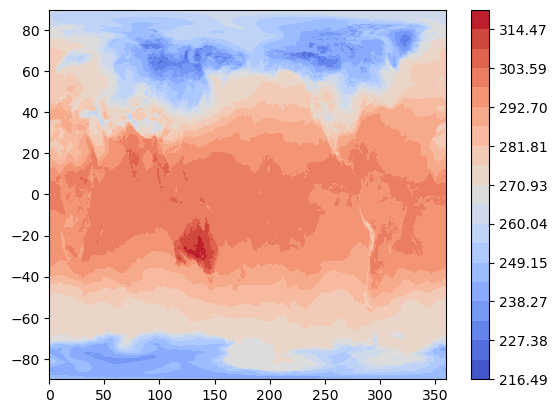

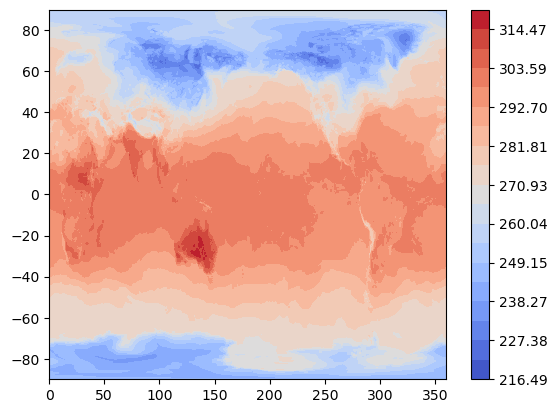

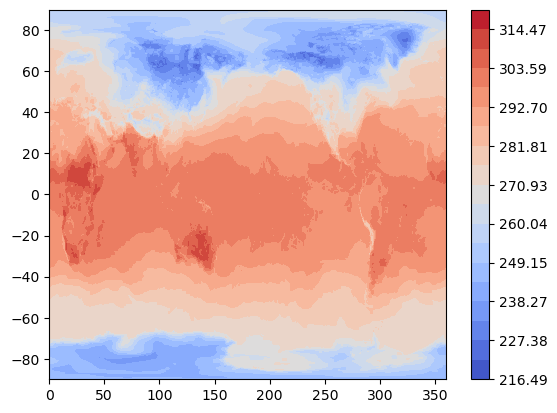

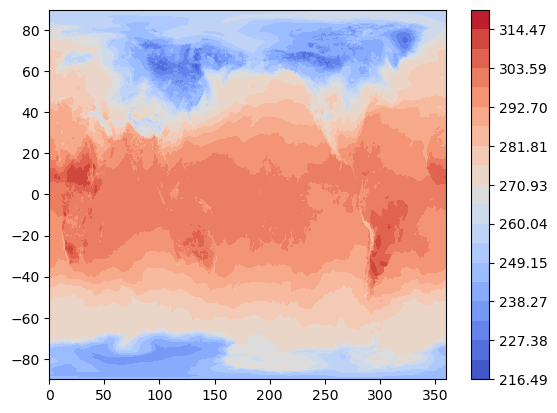

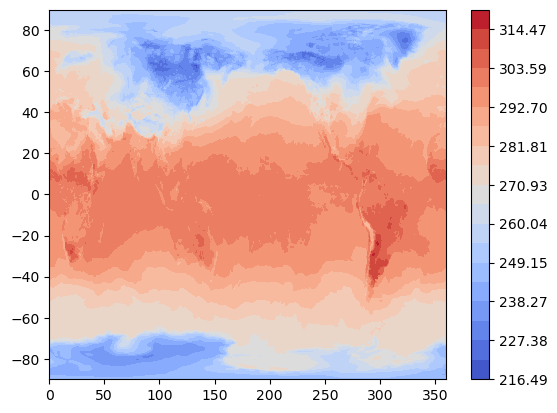

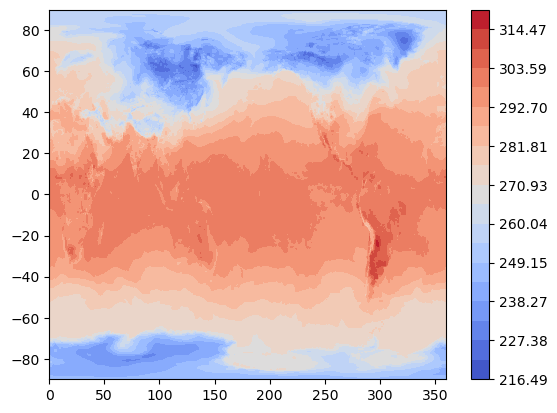

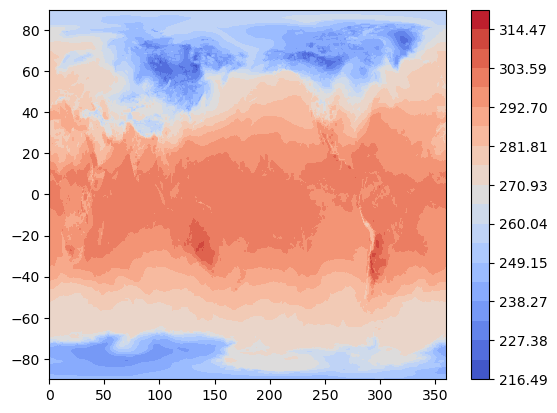

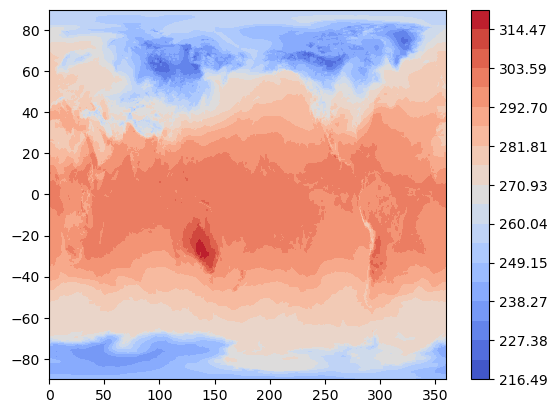

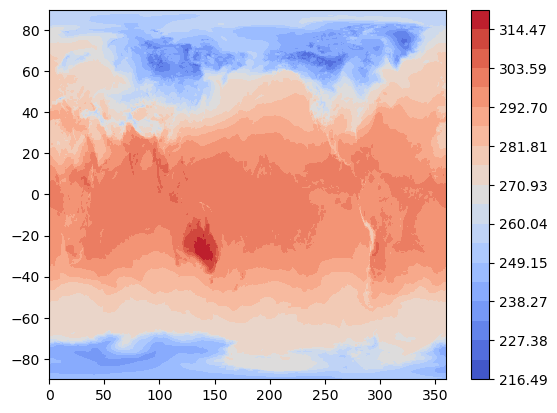

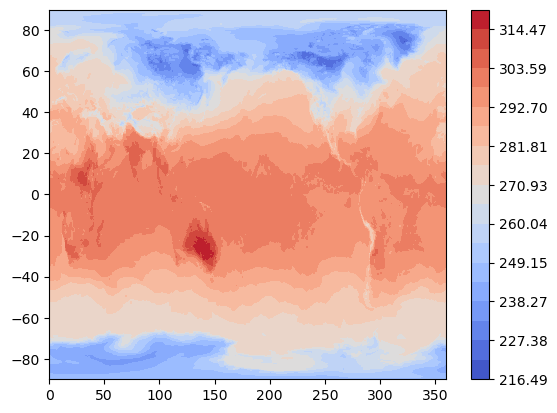

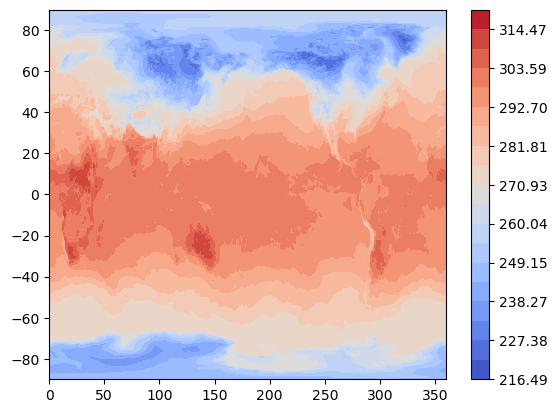

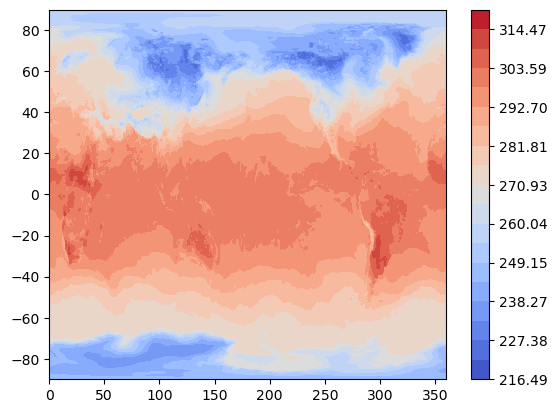

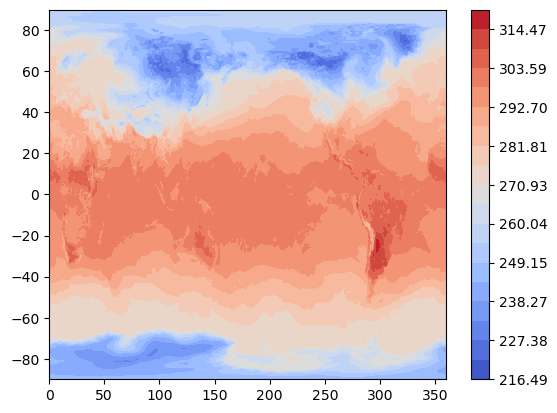

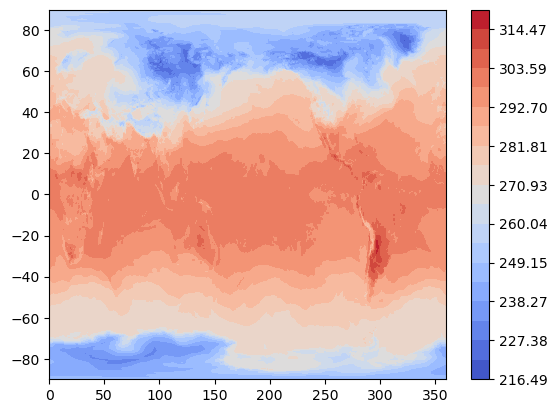

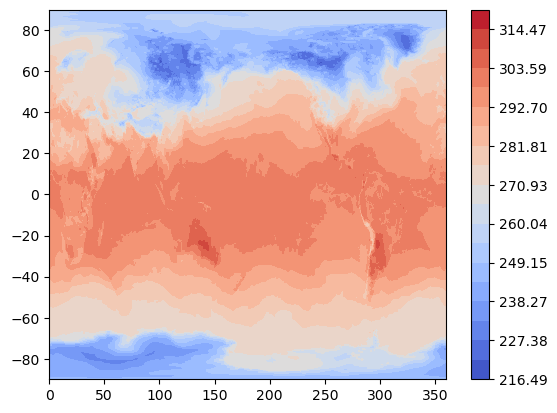

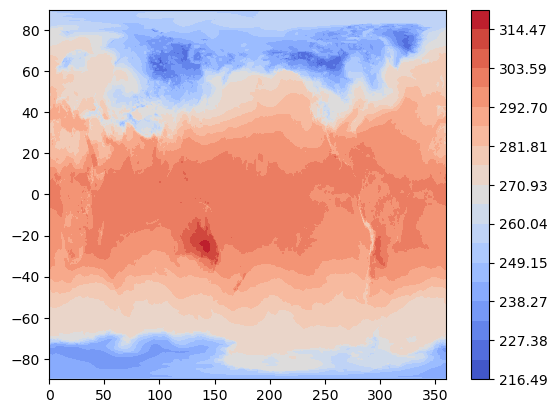

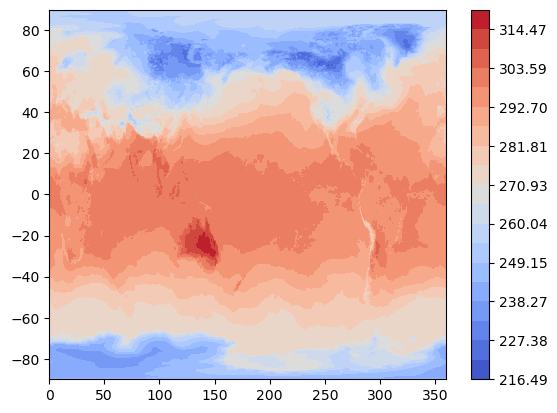

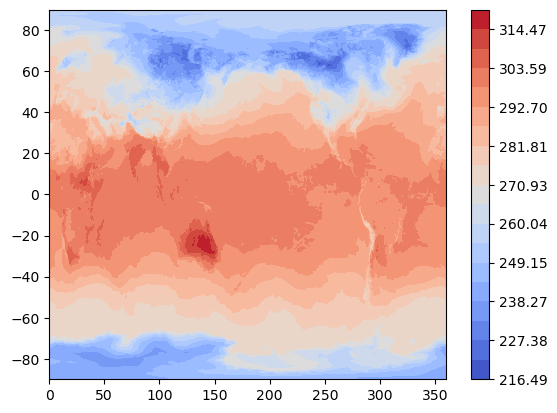

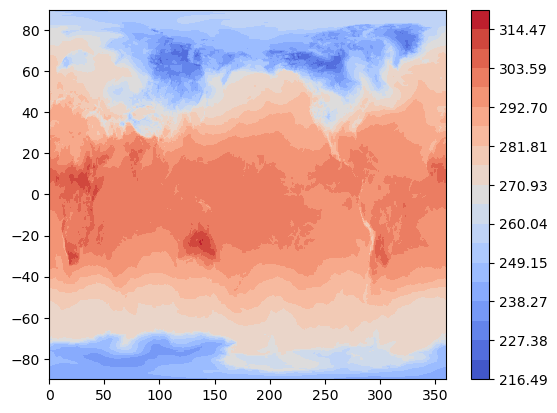

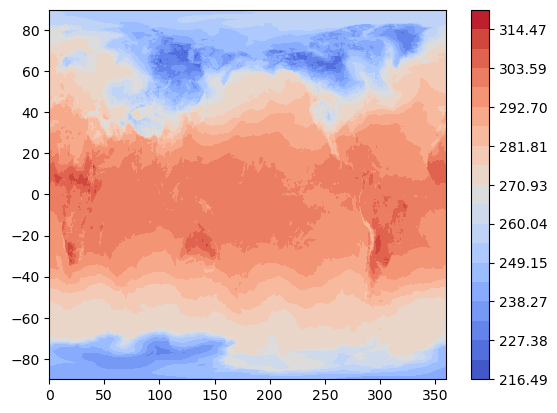

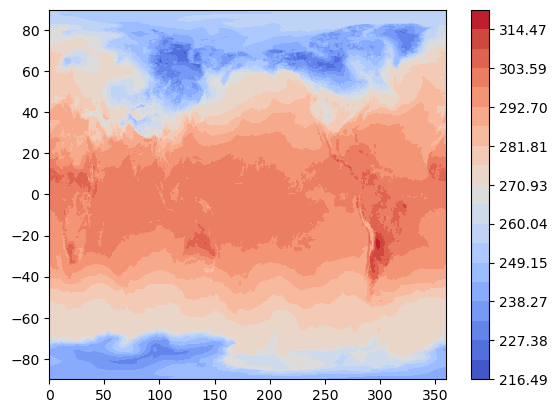

In [3]:
# plot the first time step

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import glob
import imageio

min_T = ds['2t'].min().values
max_T = ds['2t'].max().values
print(min_T, max_T)

for i in range(0,len(ds['time'])):
               plt.figure()
               plt.contourf(ds['longitude'], ds['latitude'], ds['2t'].isel(time=i), levels=np.linspace(min_T, max_T, 20), cmap='coolwarm')
               plt.colorbar()
               plt.savefig(f'/work/FAC/FGSE/IDYST/tbeucler/default/fabien/repos/curnagl/climatology/plots/2m_temperature_1_0_{i}.png')


In [4]:
images = glob.glob('/work/FAC/FGSE/IDYST/tbeucler/default/fabien/repos/curnagl/climatology/plots/2m_temperature_1_0_*.png')
gifs = [imageio.imread(image) for image in images]
imageio.mimsave('/work/FAC/FGSE/IDYST/tbeucler/default/fabien/repos/curnagl/climatology/plots/2m_temperature_1_0.gif', gifs, duration=0.1)

/tmp/44419374/ipykernel_1079799/1801414950.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  gifs = [imageio.imread(image) for image in images]
